# Natural Language Processing (Part 2)

Many of the examples and pieces of the code are taken from the "Deep Learning with Python" book by Francois Chollet... We've recommended it before, but it is a well done book so let us recommend it again!

In [1]:
import gensim.downloader as api
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.decomposition import PCA
from tensorflow.keras import preprocessing
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.utils import to_categorical

np.set_printoptions(precision=2, suppress=True, linewidth=140)
%matplotlib inline

In [2]:
!pip install gensim

You should consider upgrading via the '/Users/fabrizio/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


## Text data can be challenging to work with

Text data introduces a variety of unique challenges, some of which we've already discussed in previous lectures. We summarize some of these challenges below,

* Textual data is inherently _not_ numeric while the methods we have learned require numeric data
* The same word can be used differently in different contexts, i.e. "The new Apple product is great." vs "This apple is delicious"
* Text data is high dimensional -- Most languages have between 100,000 and 1,000,000 words.
* Text data is often not structured in the same way that we're used to. How should we account for document structure like sentences, paragraphs, and quotes?

## Review:

Let's quickly review some of the concepts from our previous lecture on NLP.

Our main goal was to "tokenize" the text that we were working with. Tokenization is the process by which we convert the textual data into a numeric representation. In our last notebook, we did this in two steps:

* Preprocessing
* Bag of words

### Preprocessing

In order to process textual data, we needed a way to convert it into numerical data. The first step of this was to preprocess the data by separating the words and normalizing them via a few steps, i.e.

> The quick brown fox jumped over the lazy dog.

became

```python
processed_text = [
    "the", "quick", "brown", "fox",
    "jump", "over", "the", "lazy", "dog"
]
```

### Bag of words

Once we had processed the text, we used two versions of the _bag of words_ algorithm. In a bag of words style algorithm for converting text to numbers, we ignore the order of the words and simply consider an $N$ element vector where $N$ is the "size of our vocabulary". The elements of this vector are assigned based on the algorithm used.

* Binary presence: Each word becomes an element of the vector and receives a 1 if the word appears at all in the text and a 0 if the word does not appear in the text
* N-gram: The elements of the vector correspond to either the number of times that a particular word appears or the frequency with which it appears

**Shortcomings**

The main shortcoming of this style of algorithm is that it ignores order! Ignoring order means that it will be difficult to distinguish between how the word "apple" is used in different contexts like from the example above.

Keras makes both of these easy and we should use their functionality whenever possible!

In [3]:
sentences = [
    "The quick brown fox jumps over the lazy dog",
    "The quick red fox jumps over the sleepy dog",
    "The quick brown fox finds the destructive groundhogs"
]

In [4]:
tokenizer = Tokenizer(num_words=14)

tokenizer.fit_on_texts(sentences)

tokenizer.word_index

{'the': 1,
 'quick': 2,
 'fox': 3,
 'brown': 4,
 'jumps': 5,
 'over': 6,
 'dog': 7,
 'lazy': 8,
 'red': 9,
 'sleepy': 10,
 'finds': 11,
 'destructive': 12,
 'groundhogs': 13}

In [5]:
tokenizer.texts_to_matrix(sentences, mode="binary")

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0.],
       [0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.]])

In [6]:
tokenizer.texts_to_matrix(sentences, mode="count")

array([[0., 2., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 2., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0.],
       [0., 2., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1.]])

In [7]:
tokenizer.texts_to_matrix(sentences, mode="freq")

array([[0.  , 0.22, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.11, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.22, 0.11, 0.11, 0.  , 0.11, 0.11, 0.11, 0.  , 0.11, 0.11, 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.12, 0.12, 0.12, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.12, 0.12]])

## Advanced tokenization

We discuss two additional methods that can be used to tokenize our data:

* one-hot encoding
* word embeddings

### One-hot encoding

One-hot encoding methods are the same idea as how one-hot encoding is used for categorical data. We consider $N$ unique possible words and then embed the sentence using vectors that have many 0s and a single 1.

For example,

> The quick brown fox jumped over the lazy dog

would be expressed by:

```python
tokenized_sentence = np.array(
    [[1, 0, 0, 0, 0, 0, 0, 0],  # The
    [0, 1, 0, 0, 0, 0, 0, 0],  # quick
    [0, 0, 1, 0, 0, 0, 0, 0],  # brown
    [0, 0, 0, 1, 0, 0, 0, 0],  # fox
    [0, 0, 0, 0, 1, 0, 0, 0],  # jump
    [0, 0, 0, 0, 0, 1, 0, 0],  # over
    [1, 0, 0, 0, 0, 0, 0, 0],  # the
    [0, 0, 0, 0, 0, 0, 1, 0],  # lazy
    [0, 0, 0, 0, 0, 0, 0, 1]],  # dog
)
```

Make note that the columns could be in a different order. (Why?)

**Implementing one-hot encoding**

While it would be relatively straightforward to write our own version of one-hot encoding, `keras` takes care of various details for us automatically and we should leverage these tools.

In [8]:
sentence = "The quick brown fox jumped over the lazy dog"

In [9]:
one_hot(sentence, 9)

[6, 2, 1, 3, 2, 7, 6, 5, 2]

In [10]:
to_categorical(
    one_hot(sentence, n=9)
)

array([[0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

Wait... This doesn't look right.

Under the hood, keras is actually using one-hot hashing. If the number of words in your dictionary is "too small" then you can wind up with "hash collisions" which makes the algorithm think that two distinct words are the same... We found this on [StackOverflow](https://stackoverflow.com/questions/66507613/confused-by-output-of-keras-text-preprocessing-one-hot)

Let's try with a larger vocabulary

In [11]:
# Choose n to be very large so that we don't have collisons
word_nums = one_hot(sentence, n=1000)
my_encoding = dict(
    zip(word_nums, range(len(word_nums)))
)

ohe = to_categorical(
    np.array([my_encoding[x] for x in word_nums])
)

In [12]:
my_encoding

{890: 6, 391: 1, 417: 2, 650: 3, 488: 4, 692: 5, 907: 7, 971: 8}

In [13]:
word_nums

[890, 391, 417, 650, 488, 692, 890, 907, 971]

In [14]:
ohe

array([[0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

**Sparsity of one-hot encoding representations**

The output of the one-hot encoding tokenization is a very large (but very sparse!) representation of the text. There can be no more than one non-zero element per row.

This is a relatively inefficient way to store the data... Is there a way to lower the dimensionality?

Yes! By using something called "word embeddings"

### Word embeddings

Word embeddings are an alternative to one-hot encoding representations of text. Whereas one-hot encoding is exceptionally high dimensional and sparse, word embeddings aim to be lower dimensional but dense.

One can obtain a word embedding in one of two ways:

1. Use a prepackaged word embedding model trained by someone else (something akin to transfer learning)
2. Learn a word embedding in conjunction with the main task that you're attempting to complete

**Desired properties of an embedding**

1. Similar words produce similar outputs. "jog" and "run" and "frog" and "toad" should produce similar vectors
2. Linear substructures. The canonical example is `"king" - "man" + "woman" = "queen"`
3. Sufficiently low dimensional to be useful

**Common word embedding models**

There are a few word embedding models that are commonly used:

* Google's `Word2Vec` model trained on their Google News dataset which had ~100 billion words
* GloVe is a model trained by researchers at Stanford using a different methodology than `Word2Vec`

We will use the Google News `word2vec` model to illustrate word embeddings

In [15]:
# Big file! Will take a bit to download/load
w2v = api.load('word2vec-google-news-300')


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [16]:
w2v.get_vector("queen").shape  # 300 dimensional

(300,)

In [17]:
def display_pca_scatterplot(model, words):
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:, :2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:, 0], twodim[:, 1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

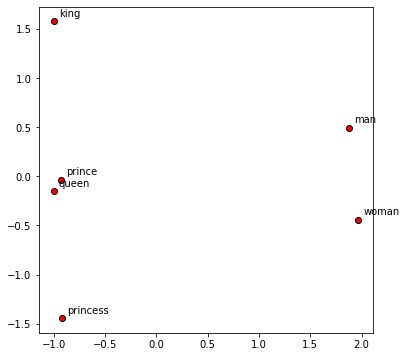

In [18]:
display_pca_scatterplot(
    w2v,
    [
        "man", "woman",
        "king", "queen",
        "prince", "princess"
    ]
)

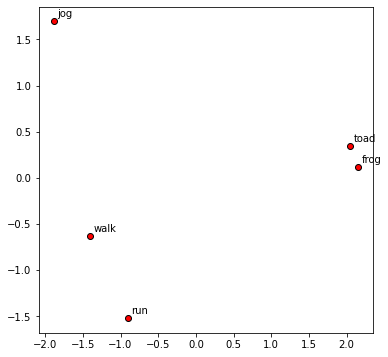

In [19]:
display_pca_scatterplot(
    w2v,
    [
        "walk", "jog", "run",
        "frog", "toad",
    ]
)

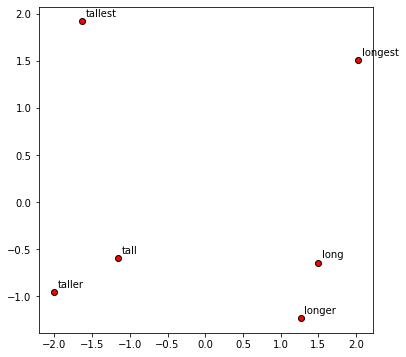

In [20]:
display_pca_scatterplot(
    w2v,
    [
        "tall", "taller", "tallest",
        "long", "longer", "longest"
    ]
)

### Training our own embedding

We can also learn our own embeddings based on a specific task.

In this example, we'll use IMDB movie review text to classify reviews as either positive or negative. We will use preprocessed data that keras provides for us.

* The `x` data contains an array or lists of integers. Each element of the array represents a single review and the list of integers is used to encode the words used in the review. For example, if `"test" -> 1` and `"case" -> 2` then `np.array([list(1, 2, 1), list(2, 1, 2)])` would represent two reviews with the words `"test case test"` and `"case test case"`.
* The `y` data contains an array of 0s and 1s. If element $i$ of this array is 1 (0) then review $i$ was positive (negative).

When we load the data, we specify the number of words that we would like to (which will keep the $n$ most commonly used words) and we then keep only the first $m$ words of each review.

In [21]:
nvocab = 10_000
nkeep = 20

(x_train, y_train), (x_test, y_test) = imdb.load_data(
    num_words=nvocab
)

x_train = preprocessing.sequence.pad_sequences(x_train, maxlen=nkeep)
x_test = preprocessing.sequence.pad_sequences(x_test, maxlen=nkeep)

17473536/17464789 [==============================] - 4s 0us/step


**`Embedding` layer**

The `Embedding` layer takes an input of integers of shape `(samples, sequence_length)` and converts them into vectors of floats with size `(samples, sequence_length, embedding_dimensionality)`.

It does this by mapping each unique integer into its own pre-specified floating point vector. For example, assume the word `good` might be represented by integer `1` and be mapped to `[0.1, 0.2, 0.3]` and word `bad` was represented by integer `2` and was mapped to `[-0.1, -0.2, -0.3]`. Then a sample of two reviews that said `"good good good"` and `"bad bad bad"` would then be represented by

```python
np.array([list(1, 1, 1), list(2, 2, 2)])
```

and would be assigned an embedding of

```python
np.array([
    [[0.1, 0.2, 0.3], [0.1, 0.2, 0.3], [0.1, 0.2, 0.3]],
    [[-0.1, -0.2, -0.3], [-0.1, -0.2, -0.3], [-0.1, -0.2, -0.3]
])
```

Training the embedding layer attempts to find these vectors.

Let's train an embedding for our IMDB data

In [22]:
nvocab

10000

In [23]:
nkeep

20

In [24]:
embedding_model = tf.keras.Sequential(
    [
        # Embedding layer
        tf.keras.layers.Embedding(nvocab, 32, input_length=nkeep),
        # Converts from 3D to 2d of shape (samples, maxlen*32)
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

embedding_model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

In [25]:
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 32)            320000    
                                                                 
 flatten (Flatten)           (None, 640)               0         
                                                                 
 dense (Dense)               (None, 1)                 641       
                                                                 
Total params: 320,641
Trainable params: 320,641
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = embedding_model.fit(
    x_train, y_train,
    epochs=10, batch_size=64,
    validation_data=(x_test, y_test)
)

Epoch 1/10
391/391 [==============================] - 6s 8ms/step - loss: 0.6385 - acc: 0.6618 - val_loss: 0.5515 - val_acc: 0.7292
Epoch 2/10
391/391 [==============================] - 2s 6ms/step - loss: 0.4796 - acc: 0.7774 - val_loss: 0.4829 - val_acc: 0.7632
Epoch 3/10
391/391 [==============================] - 3s 8ms/step - loss: 0.4105 - acc: 0.8155 - val_loss: 0.4725 - val_acc: 0.7684
Epoch 4/10
391/391 [==============================] - 3s 9ms/step - loss: 0.3648 - acc: 0.8432 - val_loss: 0.4742 - val_acc: 0.7702
Epoch 5/10
391/391 [==============================] - 4s 10ms/step - loss: 0.3239 - acc: 0.8667 - val_loss: 0.4847 - val_acc: 0.7672
Epoch 6/10
391/391 [==============================] - 3s 8ms/step - loss: 0.2847 - acc: 0.8882 - val_loss: 0.4977 - val_acc: 0.7628
Epoch 7/10
391/391 [==============================] - 4s 10ms/step - loss: 0.2471 - acc: 0.9081 - val_loss: 0.5138 - val_acc: 0.7602
Epoch 8/10
391/391 [==============================] - 5s 12ms/step - loss:

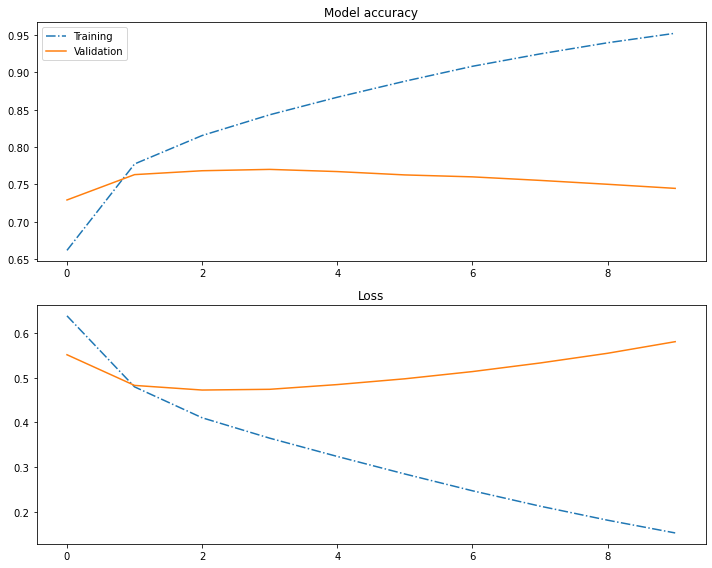

In [27]:
def make_acc_loss_plot(history):

    epoch = history.epoch

    fig, ax = plt.subplots(2, 1, figsize=(10, 8))

    # Accuracy
    ax[0].plot(epoch, history.history["acc"], linestyle="-.", label="Training")
    ax[0].plot(epoch, history.history["val_acc"], linestyle="-", label="Validation")
    ax[0].legend()
    ax[0].set_title("Model accuracy")

    # Loss
    ax[1].plot(epoch, history.history["loss"], linestyle="-.")
    ax[1].plot(epoch, history.history["val_loss"])
    ax[1].set_title("Loss")

    fig.tight_layout()

    return fig

make_acc_loss_plot(history);

## Can we do better?

The dense layer we used in training our own embedding seems to have performed relatively well, but the dense layer only observes each word as a separate entity and ignores the fact that combinations of words might mean something...

Do we know any methods that allow us to analyze data sequentially?

**Recurrent neural networks strike again!**

The other main application of recurrent neural networks is text analysis because they use "memory" to understand the context of certain sentences.

In our example, the sentence, "This move is the bomb" is much different than the sentence, "This movie is a bomb"...

_Simple RNN_

In [28]:
simple_rnn = tf.keras.Sequential(
    [
        # Embedding layer
        tf.keras.layers.Embedding(nvocab, 32, input_length=nkeep),
        tf.keras.layers.SimpleRNN(8, return_sequences=False),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

simple_rnn.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

simple_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 32)            320000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 8)                 328       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 320,337
Trainable params: 320,337
Non-trainable params: 0
_________________________________________________________________


In [29]:
simple_rnn_history = simple_rnn.fit(
    x_train, y_train,
    epochs=10, batch_size=64,
    validation_data=(x_test, y_test)
)

Epoch 1/10
391/391 [==============================] - 11s 16ms/step - loss: 0.5812 - acc: 0.6852 - val_loss: 0.5035 - val_acc: 0.7561
Epoch 2/10
391/391 [==============================] - 5s 14ms/step - loss: 0.4366 - acc: 0.8000 - val_loss: 0.4894 - val_acc: 0.7638
Epoch 3/10
391/391 [==============================] - 5s 12ms/step - loss: 0.3747 - acc: 0.8354 - val_loss: 0.5049 - val_acc: 0.7616
Epoch 4/10
391/391 [==============================] - 5s 12ms/step - loss: 0.3231 - acc: 0.8619 - val_loss: 0.5286 - val_acc: 0.7513
Epoch 5/10
391/391 [==============================] - 5s 13ms/step - loss: 0.2760 - acc: 0.8872 - val_loss: 0.5866 - val_acc: 0.7315
Epoch 6/10
391/391 [==============================] - 5s 12ms/step - loss: 0.2345 - acc: 0.9062 - val_loss: 0.6185 - val_acc: 0.7310
Epoch 7/10
391/391 [==============================] - 5s 12ms/step - loss: 0.1989 - acc: 0.9218 - val_loss: 0.6648 - val_acc: 0.7260
Epoch 8/10
391/391 [==============================] - 5s 13ms/step -

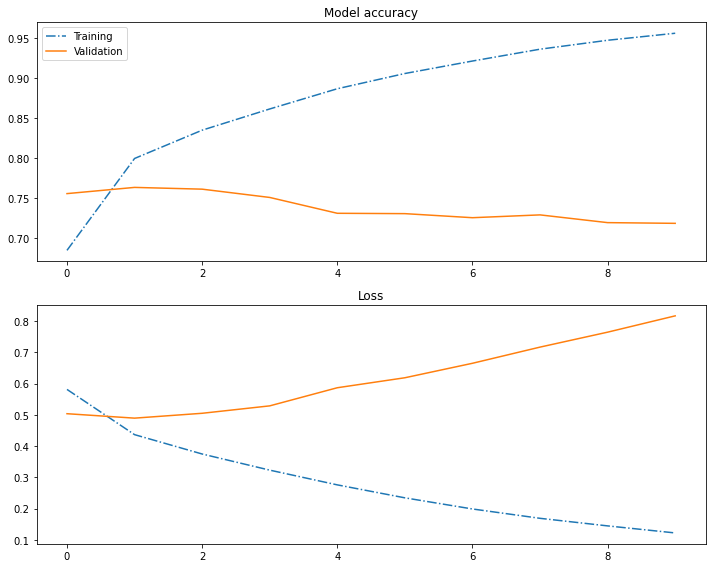

In [30]:
make_acc_loss_plot(simple_rnn_history);

_LSTM RNN_

In [31]:
lstm_rnn = tf.keras.Sequential(
    [
        # Embedding layer
        tf.keras.layers.Embedding(nvocab, 32, input_length=nkeep),
        tf.keras.layers.LSTM(8, return_sequences=False),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

lstm_rnn.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

lstm_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 32)            320000    
                                                                 
 lstm (LSTM)                 (None, 8)                 1312      
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 321,321
Trainable params: 321,321
Non-trainable params: 0
_________________________________________________________________


In [32]:
lstm_rnn_history = lstm_rnn.fit(
    x_train, y_train,
    epochs=10, batch_size=64,
    validation_data=(x_test, y_test)
)

Epoch 1/10
391/391 [==============================] - 14s 23ms/step - loss: 0.5657 - acc: 0.7117 - val_loss: 0.4887 - val_acc: 0.7605
Epoch 2/10
391/391 [==============================] - 7s 19ms/step - loss: 0.4378 - acc: 0.7937 - val_loss: 0.4731 - val_acc: 0.7702
Epoch 3/10
391/391 [==============================] - 7s 19ms/step - loss: 0.4003 - acc: 0.8183 - val_loss: 0.4684 - val_acc: 0.7727
Epoch 4/10
391/391 [==============================] - 7s 19ms/step - loss: 0.3790 - acc: 0.8286 - val_loss: 0.4808 - val_acc: 0.7698
Epoch 5/10
391/391 [==============================] - 8s 19ms/step - loss: 0.3610 - acc: 0.8380 - val_loss: 0.4908 - val_acc: 0.7681
Epoch 6/10
391/391 [==============================] - 7s 18ms/step - loss: 0.3448 - acc: 0.8462 - val_loss: 0.5021 - val_acc: 0.7656
Epoch 7/10
391/391 [==============================] - 7s 18ms/step - loss: 0.3282 - acc: 0.8567 - val_loss: 0.5007 - val_acc: 0.7648
Epoch 8/10
391/391 [==============================] - 7s 18ms/step -

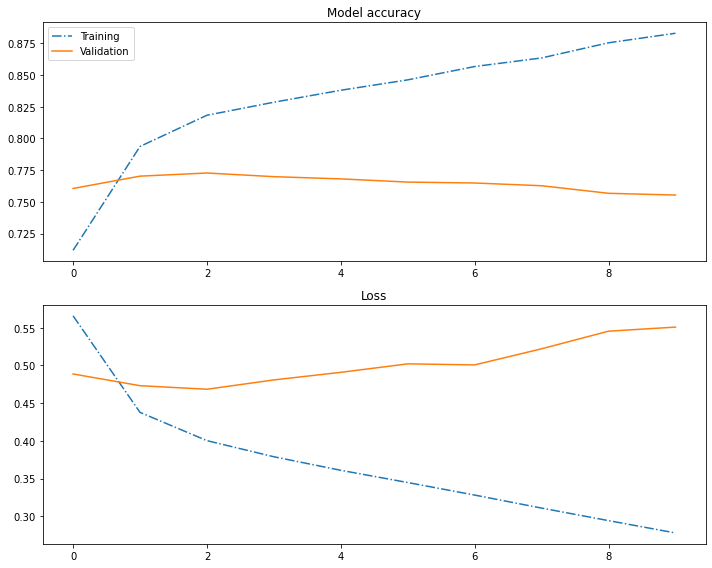

In [33]:
make_acc_loss_plot(lstm_rnn_history);

_GRU RNN_

In [34]:
gru_rnn = tf.keras.Sequential(
    [
        # Embedding layer
        tf.keras.layers.Embedding(nvocab, 32, input_length=nkeep),
        tf.keras.layers.GRU(8, return_sequences=False),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

gru_rnn.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])

gru_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 32)            320000    
                                                                 
 gru (GRU)                   (None, 8)                 1008      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 321,017
Trainable params: 321,017
Non-trainable params: 0
_________________________________________________________________


In [35]:
gru_rnn_history = gru_rnn.fit(
    x_train, y_train,
    epochs=10, batch_size=64,
    validation_data=(x_test, y_test)
)

Epoch 1/10
391/391 [==============================] - 15s 24ms/step - loss: 0.5801 - acc: 0.6874 - val_loss: 0.4900 - val_acc: 0.7595
Epoch 2/10
391/391 [==============================] - 10s 25ms/step - loss: 0.4448 - acc: 0.7892 - val_loss: 0.4780 - val_acc: 0.7694
Epoch 3/10
391/391 [==============================] - 9s 23ms/step - loss: 0.4103 - acc: 0.8115 - val_loss: 0.4806 - val_acc: 0.7709
Epoch 4/10
391/391 [==============================] - 8s 19ms/step - loss: 0.3908 - acc: 0.8251 - val_loss: 0.4881 - val_acc: 0.7646
Epoch 5/10
391/391 [==============================] - 7s 18ms/step - loss: 0.3768 - acc: 0.8321 - val_loss: 0.4908 - val_acc: 0.7683
Epoch 6/10
391/391 [==============================] - 6s 16ms/step - loss: 0.3652 - acc: 0.8364 - val_loss: 0.4932 - val_acc: 0.7701
Epoch 7/10
391/391 [==============================] - 9s 23ms/step - loss: 0.3543 - acc: 0.8446 - val_loss: 0.4847 - val_acc: 0.7689
Epoch 8/10
391/391 [==============================] - 9s 23ms/step 

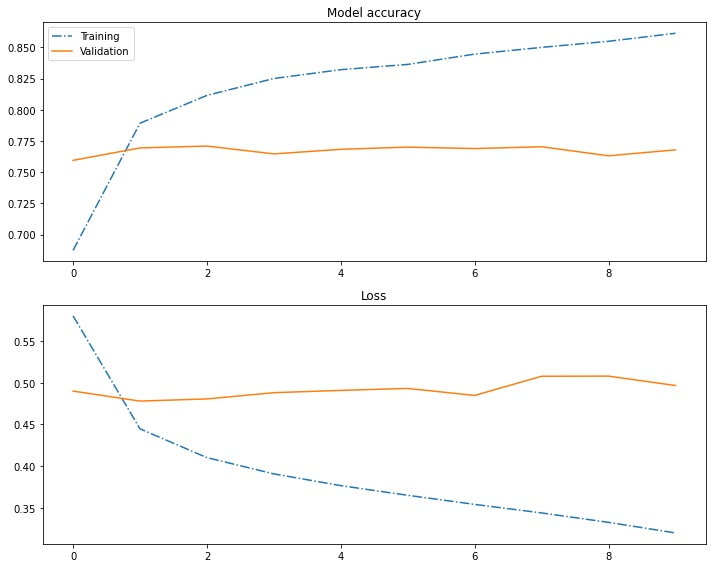

In [36]:
make_acc_loss_plot(gru_rnn_history);

### Challenge: Train a better model

I'm going to restrict myself to about 10 minutes to train a better model for sentiment analysis using a RNN. I'll post the output of each of my models below and we can talk about why I tried some of the things that I tried.

In [37]:
def test_a_model(model):
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
    print(model.summary())
    history = model.fit(
        x_train, y_train,
        epochs=10, batch_size=64,
        validation_data=(x_test, y_test)
    )

    make_acc_loss_plot(history)

    return model

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 20, 10)            100000    
                                                                 
 gru_1 (GRU)                 (None, 4)                 192       
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 100,197
Trainable params: 100,197
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
391/391 [==============================] - 13s 27ms/step - loss: 0.6310 - acc: 0.6482 - val_loss: 0.5229 - val_acc: 0.7391
Epoch 2/10
391/391 [==============================] - 10s 25ms/step - loss: 0.4683 - acc: 0.7754 - val_loss: 0.4814 - val_acc: 0.7690
Epoch 3/10
391/391 [===================

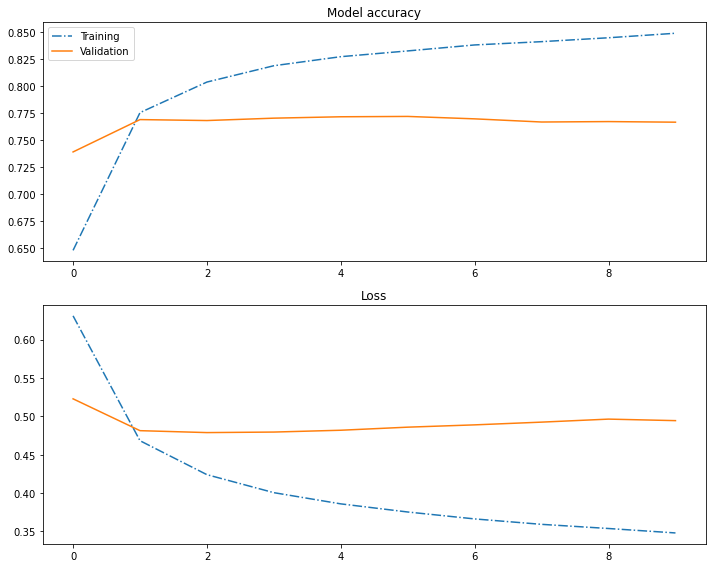

In [38]:
model_1 = tf.keras.Sequential(
    [
        # Embedding layer
        tf.keras.layers.Embedding(nvocab, 10, input_length=nkeep),
        tf.keras.layers.GRU(4, return_sequences=False),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

test_a_model(model_1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 20, 10)            100000    
                                                                 
 gru_2 (GRU)                 (None, 8)                 480       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 100,489
Trainable params: 100,489
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
391/391 [==============================] - 13s 22ms/step - loss: 0.5888 - acc: 0.6826 - val_loss: 0.5011 - val_acc: 0.7507
Epoch 2/10
391/391 [==============================] - 8s 20ms/step - loss: 0.4542 - acc: 0.7845 - val_loss: 0.4879 - val_acc: 0.7612
Epoch 3/10
391/391 [====================

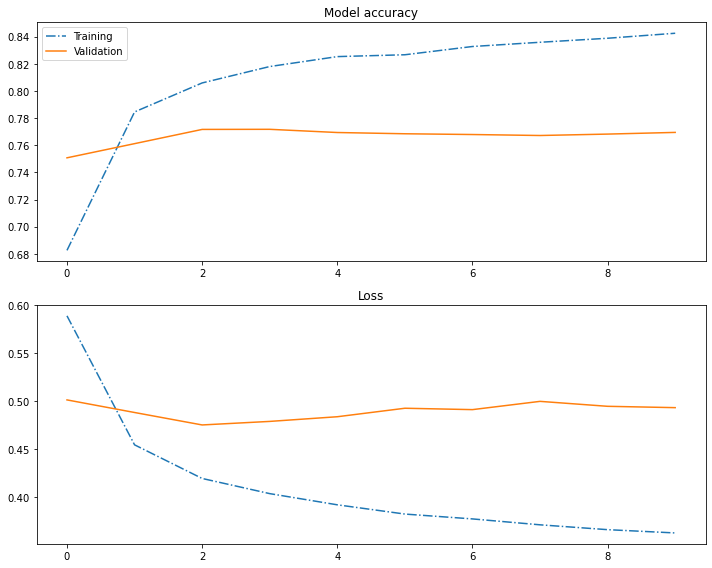

In [39]:
model_2 = tf.keras.Sequential(
    [
        # Embedding layer
        tf.keras.layers.Embedding(nvocab, 10, input_length=nkeep),
        tf.keras.layers.GRU(8, dropout=0.1, return_sequences=False),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

test_a_model(model_2)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 20, 10)            100000    
                                                                 
 gru_3 (GRU)                 (None, 20, 8)             480       
                                                                 
 gru_4 (GRU)                 (None, 2)                 72        
                                                                 
 dense_6 (Dense)             (None, 1)                 3         
                                                                 
Total params: 100,555
Trainable params: 100,555
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
391/391 [==============================] - 18s 33ms/step - loss: 0.6053 - acc: 0.6700 - val_loss: 0.5117 - val_acc: 0.7516
Epoch 2/10
391/391 [=====================

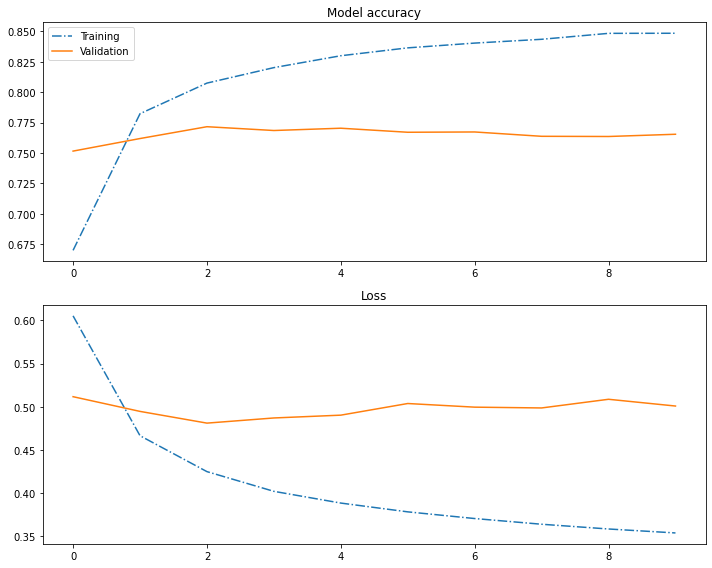

In [40]:
model_3 = tf.keras.Sequential(
    [
        # Embedding layer
        tf.keras.layers.Embedding(nvocab, 10, input_length=nkeep),
        tf.keras.layers.GRU(8, return_sequences=True),
        tf.keras.layers.GRU(2, dropout=0.1, return_sequences=False),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

test_a_model(model_3)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 20, 20)            200000    
                                                                 
 gru_5 (GRU)                 (None, 20, 8)             720       
                                                                 
 gru_6 (GRU)                 (None, 2)                 72        
                                                                 
 dense_7 (Dense)             (None, 1)                 3         
                                                                 
Total params: 200,795
Trainable params: 200,795
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
391/391 [==============================] - 27s 51ms/step - loss: 0.5915 - acc: 0.6778 - val_loss: 0.5005 - val_acc: 0.7560
Epoch 2/10
391/391 [=====================

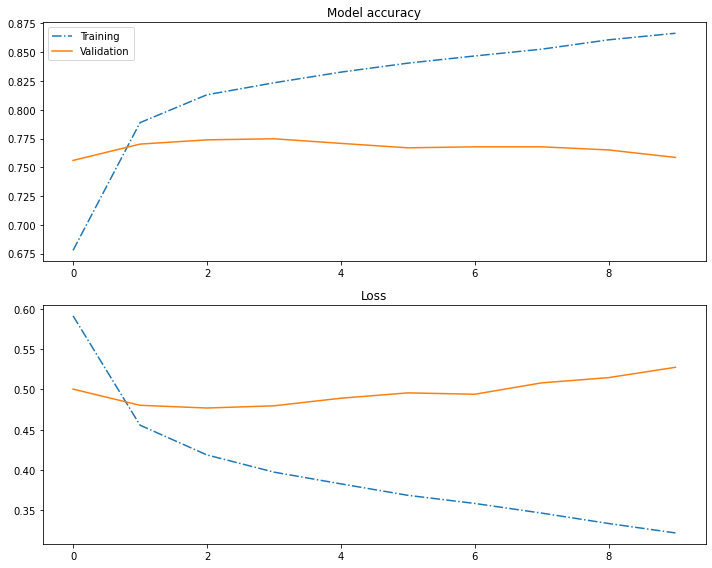

In [41]:
model_4 = tf.keras.Sequential(
    [
        # Embedding layer
        tf.keras.layers.Embedding(nvocab, 20, input_length=nkeep),
        tf.keras.layers.GRU(8, return_sequences=True),
        tf.keras.layers.GRU(2, dropout=0.1, return_sequences=False),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

test_a_model(model_4)

In [42]:
model_5 = tf.keras.Sequential(
    [
        # Embedding layer
        tf.keras.layers.Embedding(nvocab, 10, input_length=nkeep),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ]
)

test_a_model(model_5)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 20, 10)            100000    
                                                                 
 dense_8 (Dense)             (None, 20, 8)             88        
                                                                 
 dense_9 (Dense)             (None, 20, 1)             9         
                                                                 
Total params: 100,097
Trainable params: 100,097
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10


ValueError: in user code:

    File "/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 860, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/keras/engine/training.py", line 918, in compute_loss
        return self.compiled_loss(
    File "/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 141, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 245, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/keras/losses.py", line 1932, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/Users/fabrizio/opt/anaconda3/lib/python3.8/site-packages/keras/backend.py", line 5247, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)

    ValueError: `logits` and `labels` must have the same shape, received ((None, 20, 1) vs (None,)).


## References

* [Gensim documentation](https://radimrehurek.com/gensim/index.html)
* [GloVe documentation](https://nlp.stanford.edu/projects/glove/)